<a href="https://colab.research.google.com/github/rktreddy/Deep-Learning-for-Computer-Vision/blob/main/notebooks/health_analyzer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [205]:
medical_condition = pd.read_csv('medical_conditions_dataset.csv')
medical_condition.head()

,id,full_name,age,gender,smoking_status,bmi,blood_pressure,glucose_levels,condition
0,1,User0001,NaN,male,Non-Smoker,NaN,NaN,NaN,Pneumonia
1,2,User0002,30.0,male,Non-Smoker,NaN,105.315064,NaN,Diabetic
2,3,User0003,18.0,male,Non-Smoker,35.612486,NaN,NaN,Pneumonia
3,4,User0004,NaN,male,Non-Smoker,NaN,99.119829,NaN,Pneumonia
4,5,User0005,76.0,male,Non-Smoker,NaN,NaN,NaN,Diabetic


In [206]:
df = medical_condition.copy()
df['gender_smoking'] = df['gender'] + ' - ' + df['smoking_status']
df.head()

,id,full_name,age,gender,smoking_status,bmi,blood_pressure,glucose_levels,condition,gender_smoking
0,1,User0001,NaN,male,Non-Smoker,NaN,NaN,NaN,Pneumonia,male - Non-Smoker
1,2,User0002,30.0,male,Non-Smoker,NaN,105.315064,NaN,Diabetic,male - Non-Smoker
2,3,User0003,18.0,male,Non-Smoker,35.612486,NaN,NaN,Pneumonia,male - Non-Smoker
3,4,User0004,NaN,male,Non-Smoker,NaN,99.119829,NaN,Pneumonia,male - Non-Smoker
4,5,User0005,76.0,male,Non-Smoker,NaN,NaN,NaN,Diabetic,male - Non-Smoker


In [207]:
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(strategy='mean')

df[['age', 'bmi']] = mean_imputer.fit_transform(df[['age', 'bmi']])
print(df[["age", "bmi"]].isna().sum())

df['blood_pressure'] = df.groupby("gender_smoking")['blood_pressure'].transform(lambda x: x.fillna(x.mean()))
print(df[['blood_pressure']].isna().sum())

df['glucose_levels'] = df.groupby("gender_smoking")['glucose_levels'].transform(lambda x: x.fillna(x.mean()))
print(df[['glucose_levels']].isna().sum())

age    0
bmi    0
dtype: int64
blood_pressure    0
dtype: int64
glucose_levels    0
dtype: int64


In [208]:
df.drop(columns=["id", "full_name", "gender_smoking"], inplace=True)
df.head()

,age,gender,smoking_status,bmi,blood_pressure,glucose_levels,condition
0,53.541598,male,Non-Smoker,27.423420,135.170455,135.382369,Pneumonia
1,30.000000,male,Non-Smoker,27.423420,105.315064,135.382369,Diabetic
2,18.000000,male,Non-Smoker,35.612486,135.170455,135.382369,Pneumonia
3,53.541598,male,Non-Smoker,27.423420,99.119829,135.382369,Pneumonia
4,76.000000,male,Non-Smoker,27.423420,135.170455,135.382369,Diabetic


Handiling imbalanced data

In [268]:
X = df.drop(columns=["condition"])
y = df["condition"]

Feature Encoding

In [269]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

# onehot_encoder = OneHotEncoder()
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
X_ohe = onehot_encoder.fit_transform(X[categorical_columns])
# df_ohe.head()
X = pd.concat([X, X_ohe], axis=1)
X.drop(columns=categorical_columns, inplace=True)
X.head()

,age,bmi,blood_pressure,glucose_levels,gender_female,gender_male,smoking_status_Non-Smoker,smoking_status_Smoker
0,53.541598,27.423420,135.170455,135.382369,0.0,1.0,1.0,0.0
1,30.000000,27.423420,105.315064,135.382369,0.0,1.0,1.0,0.0
2,18.000000,35.612486,135.170455,135.382369,0.0,1.0,1.0,0.0
3,53.541598,27.423420,99.119829,135.382369,0.0,1.0,1.0,0.0
4,76.000000,27.423420,135.170455,135.382369,0.0,1.0,1.0,0.0


In [270]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(pd.DataFrame(y))
y

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([2, 1, 2, ..., 2, 2, 1])

In [271]:
# # convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
y = y.type(torch.LongTensor)

oversamopling using SMOTE

In [272]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [273]:
type(X_train_resampled), type(X_train)

(numpy.ndarray, torch.Tensor)

In [274]:
X_train_resampled = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_resampled = torch.tensor(y_train_resampled, dtype=torch.float32)
y_train_resampled = y_train_resampled.type(torch.LongTensor)

PyTorch

In [275]:
# class Mydata(Dataset):
#     def __init__(self, X_train, y_train):
#         super().__init__()
#         self.X = torch.from_numpy(X_train).type(torch.FloatTensor)
#         self.y = torch.from_numpy(y_train).type(torch.LongTensor)
#         self.len = self.X.shape[0]

#     def __getitem__(self, index):
#         return self.X[index], self.y[index]

#     def __len__(self):
#         return self.len

In [276]:
# # data_train = Mydata(X_train.values, y_train)  # Without resampling
# data_train = Mydata(X_train_resampled, y_train_resampled) # SMOTE resampled data
# train_loader = DataLoader(dataset=data_train, batch_size=32)

Model Architecture

In [216]:
# INPUT_NUM = data_train.X.shape[1]
# HIDDEN_NUM = 64
# OUTPUT_NUM = len(data_train.y.unique())

# class MultiClassNet(nn.Module):
#     def __init__(self, INPUT_NUM, HIDDEN_NUM, OUTPUT_NUM):
#         super().__init__()
#         self.lin1 = nn.Linear(INPUT_NUM, HIDDEN_NUM)
#         self.lin2 = nn.Linear(HIDDEN_NUM, OUTPUT_NUM)
#         self.log_softmax = nn.LogSoftmax(dim=1)

#     def forward(self, x):
#         x = self.lin1(x)
#         x = torch.sigmoid(x)
#         x = self.lin2(x)
#         x = self.log_softmax(x)
#         return x

Setting up the Training Loop

In [217]:
# model = MultiClassNet(INPUT_NUM=INPUT_NUM, HIDDEN_NUM=HIDDEN_NUM, OUTPUT_NUM=OUTPUT_NUM)

# criterion = nn.CrossEntropyLoss()
# lr = 0.1
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# NUM_EPOCHS = 100
# losses = []
# for epoch in range(NUM_EPOCHS):
#     epoch_loss = 0.0  # Initialize loss for the current epoch
#     for x, y in train_loader:

#         # Initialize gradients
#         optimizer.zero_grad()

#         # Forward pass
#         y_hat_log = model(x)

#         # Calculate loss
#         loss = criterion(y_hat_log, y)

#         # Backpropagation
#         loss.backward()

#         # Update parameters
#         optimizer.step()

#         epoch_loss += loss.item()  # Accumulate the loss for this epoch

#     average_loss = epoch_loss / len(train_loader)  # Calculate average loss for the epoch
#     losses.append(average_loss)

#     # Print epoch number and loss
#     print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Loss: {average_loss:.4f}")

Evaluating the Model

In [218]:
# # Convert the test features (X_test) from a numpy array to a PyTorch FloatTensor.
# X_test = torch.from_numpy(X_test.values).type(torch.FloatTensor)

# # Disable gradient calculation as we are in evaluation mode, which reduces memory consumption and speeds up computations.
# with torch.no_grad():
#     # Perform a forward pass through the model using the test data.
#     # y_test_hat_softmax contains the log-softmax output of the model.
#     y_test_hat_softmax = model(X_test)

#     # Use torch.max to get the predicted class labels.
#     # y_test_hat is a tuple where the first element is the max value (softmax probability)
#     # and the second element (indices) is the predicted class index.
#     y_test_hat = torch.max(y_test_hat_softmax.data, 1)

# # Convert tensors to numpy arrays for compatibility with scikit-learn's accuracy_score function.
# y_test_np = y_test  # Assuming y_test is already a numpy array, no conversion is needed here.
# y_test_hat_np = y_test_hat.indices.numpy()  # Convert the predicted class indices tensor to a numpy array.

# # Calculate and print the accuracy of the model on the test set.
# accuracy = accuracy_score(y_test_np, y_test_hat_np)
# print(f"Model Accuracy: {accuracy * 100:.2f}%")

In [219]:
# plt.plot(y_test_hat_np,'.')

In [286]:
class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(8, 32)
        self.act = nn.ReLU()
        self.output = nn.Linear(32, 3)
        # self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        # x = self.log_softmax(x)
        return x

In [287]:
X.shape, y.shape

(torch.Size([10000, 8]), torch.Size([10000]))

In [288]:
np.unique(y.values)

array([<built-in method values of Tensor object at 0x7d31f0d2b410>],
      dtype=object)

loss metric and optimizer

In [289]:
model = Multiclass()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

prepare model and training parameters

In [290]:
n_epochs = 200
batch_size = 32
batches_per_epoch = len(X_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

training loop

In [291]:
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            # X_batch = X_train[start:start+batch_size]
            # y_batch = y_train[start:start+batch_size]
            X_batch = X_train_resampled[start:start+batch_size]
            y_batch = y_train_resampled[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

Epoch 0:   0%|          | 0/218 [00:00<?, ?batch/s]


IndexError: Target 1 is out of bounds.

In [292]:
y_pred, y_batch

(tensor([[-13.6549],
         [-21.9447],
         [-23.0342],
         [-22.0179],
         [-22.6654],
         [-21.8589],
         [-21.8680],
         [-21.8680],
         [-21.8680],
         [-25.7993],
         [-21.9575],
         [-15.5675],
         [-22.7207],
         [-21.2662],
         [-21.9506],
         [-18.5329],
         [-21.7750],
         [-21.8678],
         [-21.9377],
         [-16.2113],
         [-21.7611],
         [-21.6842],
         [-21.4751],
         [-21.9344],
         [-20.9583],
         [-21.8519],
         [-22.6102],
         [-21.9064],
         [-21.8711],
         [-23.3698],
         [-21.2247],
         [-20.4265]], grad_fn=<AddmmBackward0>),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 2,
         1, 2, 0, 0, 1, 2, 0, 1]))

In [265]:
y_train.unique(return_counts=True)

(tensor([0, 1, 2]), tensor([1031, 4200, 1769]))

In [285]:
print("y_pred.shape:", y_pred.shape)
print("y_batch.shape:", y_batch.shape)
print("y_pred unique values:", y_pred.unique())
print("y_batch unique values:", y_batch.unique())

y_pred.shape: torch.Size([32, 1])
y_batch.shape: torch.Size([32])
y_pred unique values: tensor([0.], grad_fn=<Unique2Backward0>)
y_batch unique values: tensor([0, 1, 2])


In [267]:
y_train.size()

torch.Size([7000])

In [50]:
# Restore best model
model.load_state_dict(best_weights)

<All keys matched successfully>

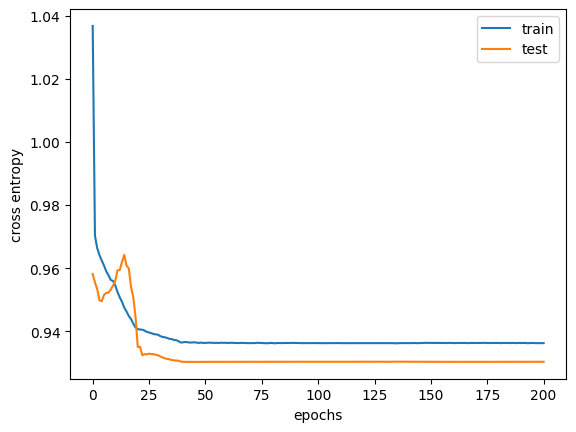

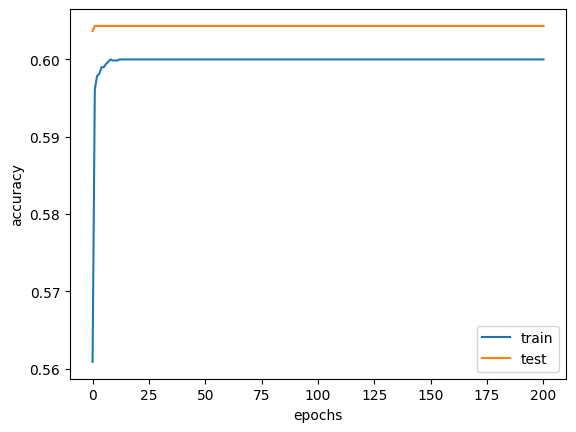

In [51]:
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [57]:
y_pred1 = model(X_test)

In [58]:
y_pred = torch.argmax(y_pred1, 1)

In [59]:
y_pred

tensor([1, 1, 1,  ..., 1, 1, 1])

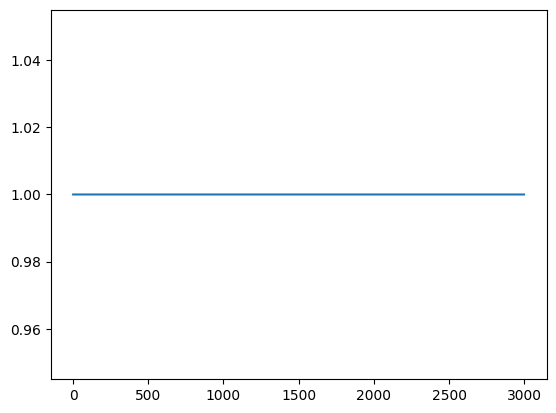

In [60]:
plt.plot(y_pred)

In [61]:
y_pred1

tensor([[-7.5320, -6.5751, -7.6735],
        [-8.1682, -7.2423, -8.0262],
        [-6.4723, -5.6186, -6.3845],
        ...,
        [-6.5452, -5.6876, -6.4336],
        [-5.3621, -4.5632, -5.3882],
        [-4.7093, -3.1574, -3.8255]], grad_fn=<AddmmBackward0>)